# **Anime recommendation**

+ Alexander Sanchez Sanchez
+ Juan David Cruz Garcia
+ Juan Sebastian Perez Camacho
+ Kennet Santiago Sanchez Roldan

### El objetivo de este proyecto es construir un modelo de inteligencia artificial que sea capaz de recomendar animes a usuarios segun que animes hayan visto estos previamente y la calificacion dada.
### La informacion utilizada aqui es extraida de Kaggle desde el enlace: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

## Carga de librerias

In [1]:
import matplotlib.pyplot as plt    #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
import seaborn as sns              #Importamos la librería Seaborn. La vamos a utilizar para graficar.
import numpy as np                 #Importamos la librería numpy para manipular arreglos.
import pandas as pd
import os
import warnings

from pathlib import Path
from sklearn.model_selection import train_test_split #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler       #Útil para escalar los atributos de entrada.

from copy import deepcopy                            #Permite hacer copias profundas. 

from sklearn.cluster import KMeans                   #Clase que implementa k-means.
from sklearn.metrics import silhouette_samples       #Útil para calcular el valor de la silueta de una observación. 
from sklearn.metrics import silhouette_score         #Útil para calcular el valor de la silueta de todas las observaciones.
from sklearn.metrics import calinski_harabasz_score  #Útil para calcular el valor del índice Calinski Harabasz (CH).
from sklearn.metrics import confusion_matrix         #Permite extraer la matriz de confusión.
from sklearn import neighbors                        #Permite utilizar el algoritmo de vecinos más cercanos.

#!pip install yellowbrick --upgrade                  #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer 
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

## **Carga de datos**

In [2]:
#Anime.csv
path = Path(os.getcwd())
path = str(path.parent.absolute())
path = path+"/datos/anime.csv"
dfAnime = pd.read_csv(path,na_values='?')   
dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [3]:
#rating.csv
path2 = Path(os.getcwd())
path2 = str(path2.parent.absolute())
path2 = path2+"/datos/rating.csv"
dfRating = pd.read_csv(path2,na_values='?')   
dfRating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## **Tipos de dato adecuados**

**Definimos tipos para cada columna del dataframe que tenga como tipo "object"**

In [4]:
#anime.csv
dfAnime['name'] = dfAnime['name'].astype("string")
dfAnime['genre'] = dfAnime['genre'].astype("string")
dfAnime['type'] = dfAnime['type'].astype("string")
dfAnime['episodes']=pd.to_numeric(dfAnime.episodes, errors='coerce').dropna().astype(int)
dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  11954 non-null  float64
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(2), int64(2), string(3)
memory usage: 672.5 KB


 **rating.csv ya tenia los tipos de datos adecuados**

## **Busqueda y eliminacion de valores nulos o duplicados**

**Vamos a buscar los valores nulos de los dataframes**

In [5]:
# anime.csv
print("La cantidad de datos nulos es:")
dfAnime.isna().sum().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

La cantidad de datos nulos es:


,anime_id,name,genre,type,episodes,rating,members
0,0,0,62,25,340,230,0


In [6]:
# Rating.csv
print("La cantidad de datos nulos es:")
dfRating.isna().sum().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

La cantidad de datos nulos es:


,user_id,anime_id,rating
0,0,0,0


+ **La cantidad de datos con valores nulos no es tan grande en comparacion al total asi que podemos borrarlos.**
+ **Eliminamos tambien los valores innecesarios. (En el caso de rating.csv, los rating con -1 son inutiles para nuestro problema puesto que simbolizan que el usuario no ha calificado el anime)**

In [7]:
dfAnime=dfAnime.dropna()
dfRating = dfRating[dfRating.rating != -1]

**Ahora buscamos el numero de datos duplicados y eliminamos en caso de que existan**

In [8]:
# Anime.csv
duplicados = dfAnime[dfAnime.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  0


In [9]:
# Rating.csv
duplicados = dfRating[dfRating.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  1


In [10]:
# Rating.csv
dfRating.drop_duplicates(keep='first',inplace=True)
duplicados = dfRating[dfRating.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  0


## Ajustes para el dataframe anime.csv

+ **Convertimos "episodes" en una variable de numeros enteros para poder realizar adecuadamente el conteo**
+ **Convertimos "type" en una variable de tipo categoria para poder realizar analisis sobre este**

In [11]:
dfAnime['episodes'] = dfAnime['episodes'].astype(int)
dfAnime=dfAnime.replace({'Movie': '0', 'TV': '1','OVA':'2','ONA':'2','Special':'3','Music':'4'})
dfAnime['type'] = dfAnime['type'].astype("category")

**Se debe tener en cuenta que el dataframe cuenta con animes de todo tipo incluyendo peliculas, esto significa que muchos de los datos se veran alterados por esto, por ejemplo, la cantidad de episodios tiende a ser 1 si el anime es del tipo pelicula mientras que las series pueden llegar incluso a 100 episodios.**

**Por ello, es apropiado partir el dataframe en 2, uno para series de anime normales y otro para peliculas, ovas, etc.
Para evitar un problema demasiado complejo, solo trabajaremos con el dataframe de series. Eliminamos la columna "type" puesto que ya no sera de utilidad**

In [12]:
df_series = dfAnime.loc[dfAnime['type'] == '1']
df_series = df_series.drop('type',axis=1)

**El dataframe tiene todos los generos de un anime en una sola columna, para que esta informacion sea util, debemos clasificarla**

**Primero observemos que categorias son las mas populares**

In [13]:
genreCount = df_series[["genre"]]
genreCount["genre"] = genreCount["genre"].str.split(", | , | ,")
genreCount = genreCount.explode("genre")
genreCount["genre"] = genreCount["genre"].str.title()

print(f'Total unique genres are {len(genreCount["genre"].unique())}')
print(f'Occurances of unique genres :')
genreCount["genre"].value_counts().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Total unique genres are 41
Occurances of unique genres :


,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Slice Of Life,School,Kids,Supernatural,Mecha,Magic,Shoujo,Historical,Ecchi,Sports,Seinen,Mystery,Super Power,Harem,Military,Space,Parody,Horror,Game,Music,Martial Arts,Psychological,Demons,Samurai,Police,Vampire,Cars,Thriller,Josei,Shoujo Ai,Shounen Ai,4,Dementia
genre,1769,1052,897,752,720,686,676,637,534,532,438,409,372,333,277,267,237,233,221,216,177,172,128,121,119,109,97,97,93,88,85,50,48,45,35,34,30,30,23,8,7


**Ahora, creemos una columna para cada uno de las 15 generos mas populares y eliminemos la columna genres**

In [14]:
def createNewColumn(colname):
    df_series[colname] = np.where(df_series.genre.str.contains(colname),1,0)
    df_series[colname] = df_series[colname].astype(int)

In [15]:
def containsGenre(dfInfo,word):  
    if str(df_series["genre"]).find(word):
        return 1
    return 0

In [16]:
#Ciclo que se encarga de crear 15 columnas de los generos mas populares
for i in range(15):
    createNewColumn(genreCount["genre"].value_counts().index.tolist()[i])


**Finalmente tenemos el siguiente dataframe**

In [17]:
df_series = df_series.drop('genre',axis=1)
df_series.head(3)

,anime_id,name,episodes,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Slice Of Life,School,Kids,Supernatural,Mecha,Magic,Shoujo
1,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0
2,28977,Gintama°,51,9.25,114262,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,24,9.17,673572,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Ajustes para el dataframe rating.csv

**Para tener certeza de que a un usuario le gusto o no un anime debemos extraer el promedio de sus calificaciones. Si la calificacion dada es mayor o igual a la media, significa que el usuario disfruto del anime, en caso contrario, se considerara una opinion negativa**

In [18]:
dfRating['ratingMean']=dfRating["rating"].mean()
dfRating['Liked']=np.where(dfRating.rating >= dfRating.ratingMean ,1,0)
dfRating.head()

,user_id,anime_id,rating,ratingMean,Liked
47,1,8074,10,7.808497,1
81,1,11617,10,7.808497,1
83,1,11757,10,7.808497,1
101,1,15451,10,7.808497,1
153,2,11771,10,7.808497,1


## Resolucion del problema

**Para resolver nuestro problema de recomendacion de anime necesitaremos dos cosas, en primer lugar, unas categorias que clasifiquen adecuadamente los animes del dataframe, una vez hecho esto, usaremos un modelo de clasificacion para adecuar los datos las clasificaciones previamente creadas**

## Construccion del modelo de clustering

**La Variable "Slice Of Life genera errores por lo que procedemos a eliminarla**

In [19]:
df_series = df_series.drop('Slice Of Life',axis=1)

**Ahora procedemos a observar las correlaciones entre los generos**

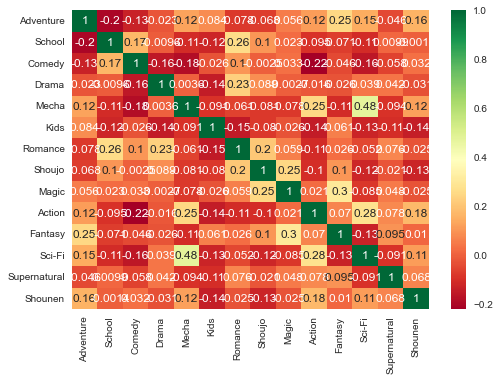

In [20]:
correlacionEntre = list(set(df_series.columns) - set(["anime_id","name","episodes","rating","members"]))
ax = sns.heatmap(df_series[correlacionEntre].corr(),annot=True,cmap='RdYlGn')

**Si bien las correlaciones no son muy altas entre si, teniendo en cuenta el contexto de los generos, podemos eliminar algunos generos que pueden ser descritos por otros.**

In [21]:
df_series = df_series.drop('Mecha',axis=1)
df_series = df_series.drop('Shoujo',axis=1)
df_series = df_series.drop('School',axis=1)

**Para construir un modelo adecuado, decidimos utilizar los generos mas populares y descartar las variables que no seran de demasiada utilidad. Ademas, normalizaremos los datos**

In [22]:
features = list(set(df_series.columns) - set(["anime_id","name","episodes"]))

rango_de_salida_de_las_variables_escaladas = (0,1)  #Tupla con el siguiente formato: (mínimo deseado, máximo deseado).
scaler = MinMaxScaler(feature_range=rango_de_salida_de_las_variables_escaladas)  #Instanciamos el objeto para escalar los datos. 

df_series_norm = deepcopy(df_series[features])  #Inicializamos este objeto con una copia profunda del las columnas de entrada de interés del dataframe.
df_series_norm[features] = scaler.fit_transform(df_series_norm) #Ajustamos y transformamos los datos.


In [23]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

kmin              = 1          #Límite inferior para explorar el número de grupos.
kmax              = 20          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 76          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.


In [24]:
df_x_norm = df_series_norm
# Vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 76   #Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script.
particion_para_pruebas = 0.2

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_train, df_x_test = train_test_split(df_x_norm,                                         
                                        test_size=particion_para_pruebas, 
                                        random_state=valor_semilla_aleatoria, 
                                        shuffle=mezclar_los_datos)

**Para tener certeza, observemos el metodo de las siluetas**

For k clusters = 2 The average silhouette_score is : 0.1744407890268183


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


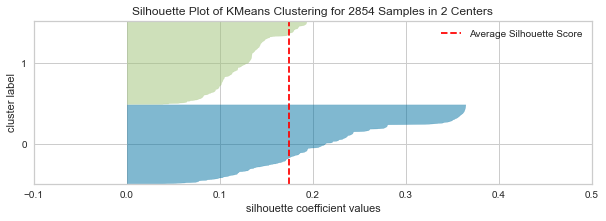

For k clusters = 3 The average silhouette_score is : 0.17772549941804727


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


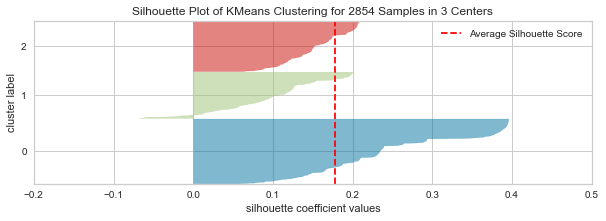

For k clusters = 4 The average silhouette_score is : 0.17691548921839867


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


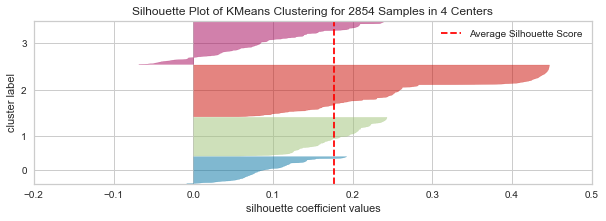

For k clusters = 5 The average silhouette_score is : 0.1824087449851955


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


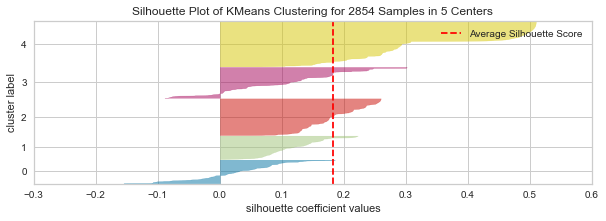

For k clusters = 6 The average silhouette_score is : 0.1964517851109152


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


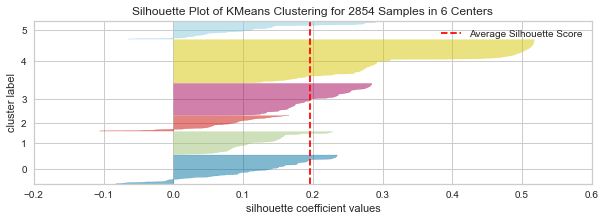

For k clusters = 7 The average silhouette_score is : 0.20219899852999765


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


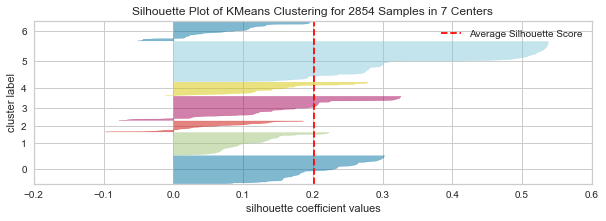

For k clusters = 8 The average silhouette_score is : 0.21250982310240246


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


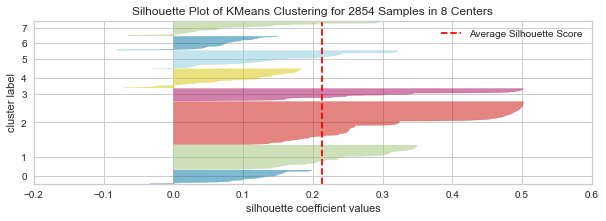

For k clusters = 9 The average silhouette_score is : 0.21881248606959436


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


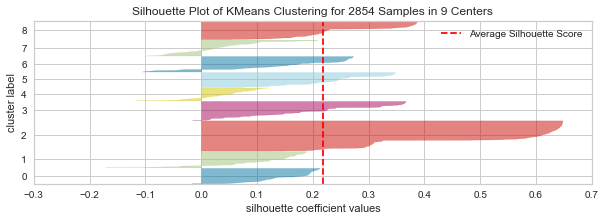

For k clusters = 10 The average silhouette_score is : 0.22317678997512275


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


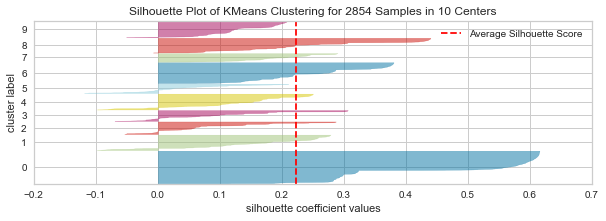

For k clusters = 11 The average silhouette_score is : 0.2326822357129925


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


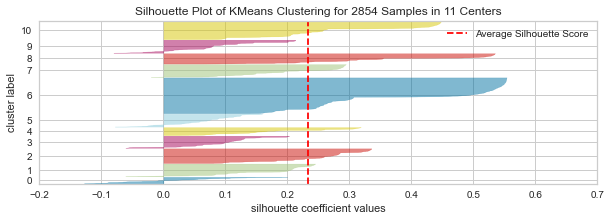

For k clusters = 12 The average silhouette_score is : 0.23055277114999345


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


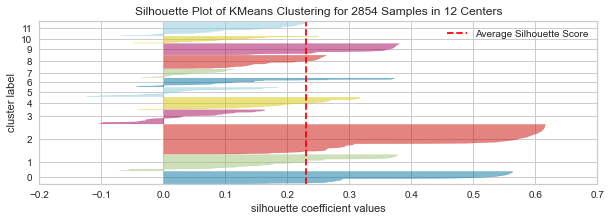

For k clusters = 13 The average silhouette_score is : 0.25159335302911223


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


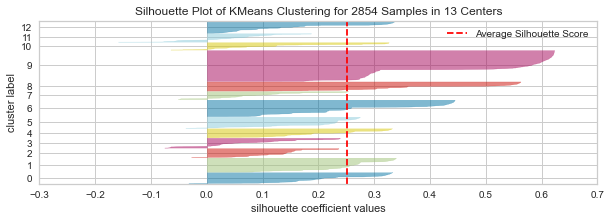

For k clusters = 14 The average silhouette_score is : 0.24565279961118483


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


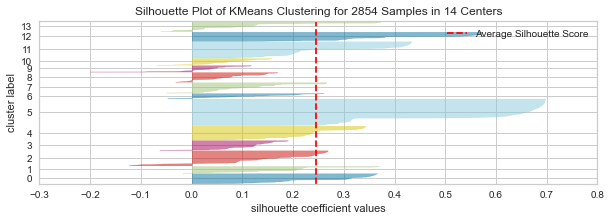

For k clusters = 15 The average silhouette_score is : 0.2512967612743029


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


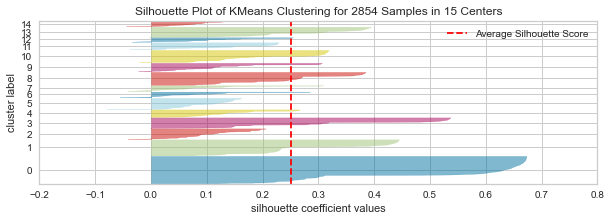

For k clusters = 16 The average silhouette_score is : 0.25372492010923364


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


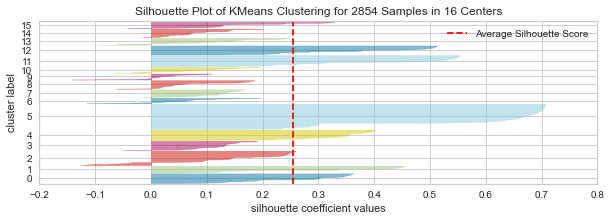

For k clusters = 17 The average silhouette_score is : 0.2637559589901205


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


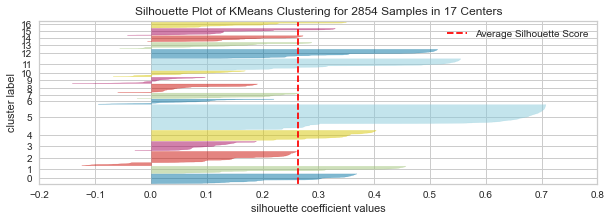

For k clusters = 18 The average silhouette_score is : 0.27646500404182556


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


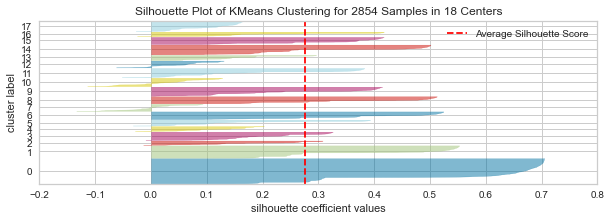

For k clusters = 19 The average silhouette_score is : 0.26999565347752885


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


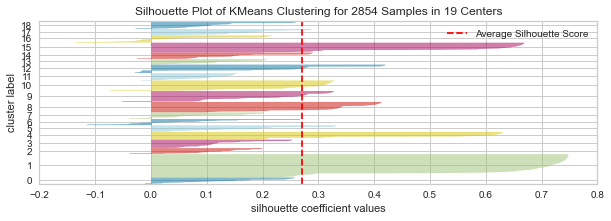

For k clusters = 20 The average silhouette_score is : 0.2890385202770909


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


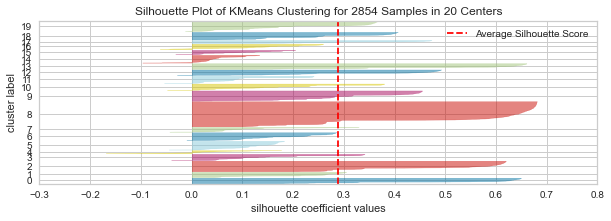

In [25]:
#Revisemos los resultados del método de la silueta para algunos valores
#"tentativos" para k:
silhouette_score_list        = []

for k in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    model3 = KMeans(n_clusters=k,         #Se define el número de grupos.
                  init=init,            #Se define el método de inicialización. Otra opción es 'random'
                  n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                  max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)
    model3.fit(df_x_train)
    sc = silhouette_score(df_x_train.values, model3.labels_)
    silhouette_score_list.append(sc)
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer5 = SilhouetteVisualizer(estimator=model3, colors='yellowbrick')
    visualizer5.fit(df_x_train)
    visualizer5.show() 

**Observemos graficas que describen los 3 indicadores para KMeans**

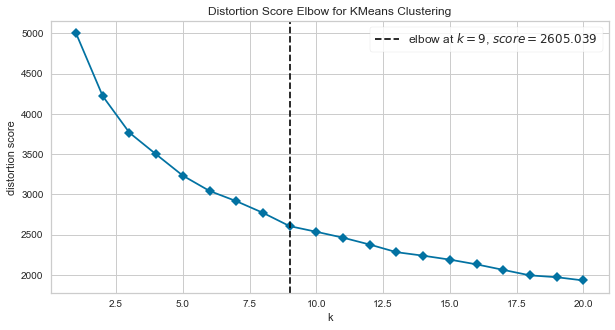

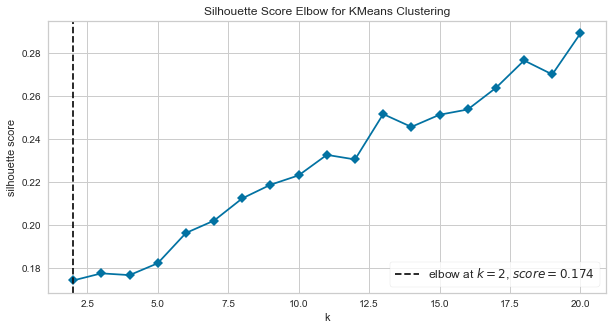

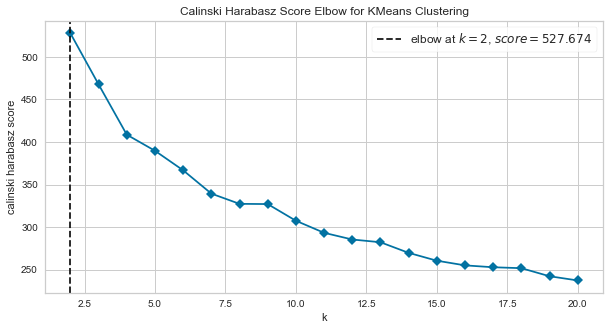

In [26]:
model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
  if metric=="silhouette" or metric=="calinski_harabasz":  
    kmin_ = max(2,kmin)
  else:
    kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
  visualizer2.show()

**Los indicadores obtenidos no encuentran un punto de decision para determinar cual valor es el mejor para K, sin embargo, como determinamos un numero de generos, es deseable que los animes se incluyan de una u otra manera en estos.**

**Inicialmente teniamos 15 generos pero como observamos, 3 de estos podian ser perfectamente descritos por otros. Por tanto, utilizaremos como valor de K el numero 12**

In [27]:
#K-means
#-------------------------------------------------------------------------------
k = 12  #Número de grupos que se escogió después del análisis previo.

#Ahora se instancia el objeto para utilizar el agrupamiento con k-means.
#Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
#Si requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                n_init       = n_init,       #Número de inicializaciones aleatorias. 
                max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state = random_seed)

#Hagamos el ajuste (i.e.: encontremos los centroides).
kmeans.fit(df_x_train)
predict = kmeans.predict(df_series_norm)

df_series['Classification'] = pd.Series(predict, index=df_series_norm.index)

In [28]:
df_series.to_csv('dfSeries.csv')

**Finalmente el dataframe con el que usaremos la clasificacion es el siguiente:**

In [29]:
df_final = pd.merge(df_series, dfRating, how='inner', left_on = 'anime_id', right_on = 'anime_id')
df_final.head(100)

,anime_id,name,episodes,rating_x,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,...,Drama,Romance,Kids,Supernatural,Magic,Classification,user_id,rating_y,ratingMean,Liked
0,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,3,10,7.808497,1
1,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,10,10,7.808497,1
2,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,11,8,7.808497,1
3,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,12,9,7.808497,1
4,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,17,10,7.808497,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,291,10,7.808497,1
96,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,294,10,7.808497,1
97,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,296,9,7.808497,1
98,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,0,1,1,0,1,...,1,0,0,0,1,10,298,10,7.808497,1


**Solo nos importan los animes que le han gustado a los usuarios**

## Construccion del modelo de clasificacion

**Ahora buscamos clasificar las variables, usaremos el algoritmo de KNN (K Nearest Neighbors). Teniendo en cuenta que clasificaremos segun lo obtenido por el modelo de clustering, es logico usar el mismo K obtenido**

### División del conjunto de datos

In [30]:
input_attr = list(set(df_series.columns) - set(["anime_id","name","episodes"]))
target_attr = 'Classification'

input_attr.remove('rating') 

print(input_attr)

df_x_knn = deepcopy(df_final[input_attr])
df_y_knn = deepcopy(df_final[target_attr])


['Classification', 'members', 'Comedy', 'Drama', 'Kids', 'Romance', 'Sci-Fi', 'Shounen', 'Adventure', 'Magic', 'Action', 'Fantasy', 'Supernatural']


In [31]:
mix = True
seed = 13

train_set = 0.6
dev_set = 0.2

train_dev_set = train_set + dev_set
test_set = 1 - train_dev_set

df_x_rest_knn, df_x_test_knn, df_y_rest_knn, df_y_test_knn = train_test_split(df_x_knn, df_y_knn, test_size=test_set, random_state=seed, shuffle=mix)

df_x_train_knn, df_x_val_knn, df_y_train_knn, df_y_val_knn = train_test_split(df_x_rest_knn, df_y_rest_knn, test_size=dev_set/train_dev_set, random_state=seed, shuffle= not mix)

### Modelo

In [32]:
k = 12

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(df_x_train_knn, df_y_train_knn)

KNeighborsClassifier(n_neighbors=12)

# Preparacion para el despliegue


## Fusion de animes

Para simular la experiencia de un usuario en una plataforma de streaming de anime, se fusionan diferentes animes teniendo en cuenta que un usuario puede gustar de mas de un anime.

In [33]:
##Eliminamos las columnas innecesarias
df_prepared=df_series
df_prepared = df_prepared.drop('episodes', axis=1)
df_prepared = df_prepared.drop('anime_id', axis=1)
df_prepared = df_prepared.drop('Classification', axis=1)

**Metodos para fusionar**

In [34]:
def fusion(first,second):
    fusiondf = first
    name = first.iloc[0][0]
    name2 = second.iloc[0][0]
    fusiondf['name'] = str(name + " "+ name2)
    rating = (float(first['rating']) + float(second['rating']))/2
    fusiondf['rating'] = rating
    members = (float(first['members']) + float(second['members']))/2
    fusiondf['members'] = members
    genreAdjustment(first,second,fusiondf)
    return fusiondf

In [35]:
def genreAdjustment(first,second,fusion):
    for column in first:
        if(column != 'name' and column != 'rating' and column != 'members'):
            fusion[column] = 1 if int(second[column]) == 1 or int(first[column]) == 1 else 0

In [36]:
def fusionByNameList(animeString):
    animeList = animeString.split(",")
    animeElement = df_prepared.loc[df_prepared['name'] == animeList[0]]
    animeElement['name'] = ""
    for name in animeList:
        secondElement = df_prepared.loc[df_prepared['name'] == name]
        animeElement = fusion(animeElement,secondElement)
    return animeElement

### Ejemplos de fusion

**Animes a fusionar:**

In [37]:
df_prepared.loc[df_prepared['name'] == "Gintama°"]

,name,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic
2,Gintama°,9.25,114262,1,1,0,1,0,1,0,0,0,0,0


In [38]:
df_prepared.loc[df_prepared['name'] == "Mushishi Zoku Shou"]

,name,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic
27,Mushishi Zoku Shou,8.8,101351,0,0,1,0,1,0,0,0,0,1,0


**Fusion:**

In [39]:
fusionByNameList("Gintama°,Mushishi Zoku Shou")

,name,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic
2,Gintama° Mushishi Zoku Shou,9.025,107806.5,1,1,1,1,1,1,0,0,0,1,0


**Podemos fusionar mas de dos animes, basta con usar el metodo de fusion las veces que sea necesario**

In [40]:
jojos = df_prepared.loc[df_prepared['name'] == "JoJo no Kimyou na Bouken: Stardust Crusaders 2nd Season"]
jojos.head()

,name,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic
64,JoJo no Kimyou na Bouken: Stardust Crusaders 2...,8.6,93657,0,1,1,0,0,1,1,0,0,1,0


**Resultado:**

In [41]:
fusionByNameList("Gintama°,Mushishi Zoku Shou,JoJo no Kimyou na Bouken: Stardust Crusaders 2nd Season")

,name,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic
2,Gintama° Mushishi Zoku Shou JoJo no Kimyou na...,8.8125,100731.75,1,1,1,1,1,1,1,0,0,1,0


## Recomendaciones 

Para realizar recomendaciones adecuadas, se consideran como factores importantes el rating y el numero de miembros que contiene un anime, por tanto se ha decidido mostrar al usuario, los animes mas populares que esten en la misma categoria que los animes que este ve.

Como ejemplo, vamos a recomendarle animes a un usuario que ha visto Pokemon.

In [44]:
def recommendation(df):
    predicted_value = int(knn.predict(df.drop('name',axis=1)))
    category=df_series[df_series.Classification == predicted_value]
    return category.sort_values(by=['members','rating'], ascending=False)

In [48]:
ex=recommendation(fusionByNameList("Pokemon"))
ex.head(10)

,anime_id,name,episodes,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic,Classification
118,19815,No Game No Life,12,8.47,602291,1,0,1,0,1,0,0,0,0,1,0,3
177,2966,Ookami to Koushinryou,13,8.37,334932,0,0,1,0,1,0,0,1,0,0,0,3
28,457,Mushishi,26,8.78,300030,0,0,1,0,1,0,0,0,0,1,0,3
495,30831,Kono Subarashii Sekai ni Shukufuku wo!,10,8.03,244877,1,0,1,0,1,0,0,0,0,1,0,3
1834,527,Pokemon,276,7.43,229157,1,1,1,0,1,0,0,0,1,0,0,3
124,5341,Ookami to Koushinryou II,12,8.46,210491,0,0,1,0,1,0,0,1,0,0,0,3
687,552,Digimon Adventure,54,7.89,182208,1,1,1,0,1,0,0,0,1,0,0,3
923,11319,Zero no Tsukaima F,12,7.77,174026,0,0,1,0,1,0,0,1,0,0,1,3
1789,14833,Maoyuu Maou Yuusha,12,7.44,164445,0,0,1,0,1,0,0,1,0,0,0,3
2035,1313,Digimon Adventure 02,50,7.37,120268,1,1,1,0,1,0,1,0,1,0,0,3


In [49]:
ex=recommendation(fusionByNameList("Fate/Zero"))
ex.head(10)

,anime_id,name,episodes,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic,Classification
86,16498,Shingeki no Kyojin,25,8.54,896229,0,1,0,0,1,1,1,0,0,0,0,5
804,11757,Sword Art Online,25,7.83,893100,0,1,1,0,1,0,0,1,0,0,0,5
643,9919,Ao no Exorcist,25,7.92,583823,0,1,0,0,1,1,0,0,0,1,0,5
2132,21881,Sword Art Online II,24,7.35,537892,0,1,1,0,1,0,0,1,0,0,0,5
775,22199,Akame ga Kill!,24,7.84,492133,0,1,1,0,1,0,0,0,0,0,0,5
94,10087,Fate/Zero,13,8.51,453630,0,1,0,0,1,0,0,0,0,1,0,5
458,4898,Kuroshitsuji,24,8.06,424919,1,1,0,0,1,1,0,0,0,1,0,5
1338,356,Fate/stay night,24,7.58,374880,0,1,0,0,1,0,0,1,0,1,1,5
1246,1195,Zero no Tsukaima,13,7.62,346828,1,1,1,0,1,0,0,1,0,0,1,5
36,11741,Fate/Zero 2nd Season,12,8.73,340973,0,1,0,0,1,0,0,0,0,1,0,5


In [56]:
ex=recommendation(fusionByNameList("Neon Genesis Evangelion"))
ex.head(10)

,anime_id,name,episodes,rating,members,Comedy,Action,Adventure,Sci-Fi,Fantasy,Shounen,Drama,Romance,Kids,Supernatural,Magic,Classification
19,1575,Code Geass: Hangyaku no Lelouch,25,8.83,715151,0,1,0,1,0,0,0,0,0,0,0,1
3,9253,Steins;Gate,24,9.17,673572,0,0,0,1,0,0,0,0,0,0,0,1
13,2904,Code Geass: Hangyaku no Lelouch R2,25,8.98,572888,0,1,0,1,0,0,1,0,0,0,0,1
29,2001,Tengen Toppa Gurren Lagann,27,8.78,562962,1,1,1,1,0,0,0,0,0,0,0,1
23,30276,One Punch Man,12,8.82,552458,1,1,0,1,0,0,0,0,0,1,0,1
98,13601,Psycho-Pass,22,8.50,509109,0,1,0,1,0,0,0,0,0,0,0,1
22,1,Cowboy Bebop,26,8.82,486824,1,1,1,1,0,0,1,0,0,0,0,1
211,30,Neon Genesis Evangelion,26,8.32,461946,0,1,0,1,0,0,1,0,0,0,0,1
830,10793,Guilty Crown,22,7.81,460959,0,1,0,1,0,0,1,0,0,0,0,1
1620,6880,Deadman Wonderland,12,7.48,453454,0,1,0,1,0,0,0,0,0,0,0,1


## Evaluacion cuantitativa del modelo

**Como medida para evaluar adecuadamente el rendimiento del modelo, se ha decidido tomar un anime de los de la lista de usuario para determinar cuantos animes que le gustan al usuario estan dentro de las recomendaciones dadas por el modelo**

In [60]:
def seenVsRecommendation(userRatings,firstRating):
    isInList = False
    percent = 0
    dfRec=recommendation(df_prepared.loc[df_prepared['name'] == firstRating['name']])
    recAnimes = dfRec['name'].unique()
    userAnimes = userRatings['name'].unique()
    for anime in recAnimes:
        if(anime in userAnimes):
            isInList = True
            percent += 1
            break
    
    return percent/len(userAnimes)

In [67]:
import random
predictions = 0
users = df_final['user_id'].unique()
for user in users:
    userRatings = df_final.loc[df_final['user_id'] == user]
    randomNumber = random.randint(0, len(userRatings)-1)
    firstRating = userRatings.iloc[randomNumber]
    percent = seenVsRecommendation(userRatings,firstRating)
    if(percent >= 0.1):
        predictions += 1
    
averagePercent = predictions/len(users)

**De esta manera se obtiene el siguiente resultado:**

In [68]:
print(averagePercent)

0.25787404430646027


**Lo que indica que en el 25% de los casos,  10% de los animes recomendados por el modelo le han gustado previamente a el usuario**